# Optimisation Implementation
- use scipy.optimisation and just return the inverse which would normally be minimised but by inverting is then maximised when inverted

- optimising with respect to $R_0$

# function

In [1]:
from scipy import exp 

def L(t, k = 0.01):
    """
        Calculates lifetime reproductive output of an organism, 
        as described in Charnov et al. 2001.

        Arguments:
            t {int} -- time
            k {float} -- reproduction senescence
        Returns:
            {float} -- lifetime reproductive output
    """
    return exp(-k*t)


def dRmdt(mR0, t, alpha = 50, M = 1000, a = 2.15, c = 0.17, rho = 0.06, k = 0.01): 
    """
    A function to simulate change in mass and reproductive output for a time point.  
    Function designed with the intention of beign integrated.
    
        Arguments:
        t {float} -- time
        mR0 {float} -- array with mass (g) and reproduction at start of time step 
        alpha {float} -- asymtotic mass (g)
        M {float} -- asymptotic mass (g)
        a {float} -- growth rate (s^-1)
        b {float} -- maintenace cost per cell ## found in function
        c {float} -- reproductive cost (s^-1)
        rho {float} -- scaling factor of reproduction 
        k {float} -- reproductive senesence
        Z {float} -- ## found in function
        
    Returns:
        {scipy.array} -- 
            dmdt --rate of change of mass in grams^1/4 per day (g^1/4 d^-1) at time t
                NOTE:  integration of dmdt will give mass at t
            Rt -- reproductive output at time t in terms of mass 
                NOTE: integration of Rt gives total Reproductive output for the bounds 
                        of the integral
    """
    # predefine outputs 
                
    m = mR0[0] 
    R = mR0[1]
    b = (a/(M**0.25)) -c 
    Z = 2/alpha
    Q = L(t-alpha, k)
    
    # conditional tree dependant on `alpha`
    if t < 0:
        return "ERROR: time < 0"
    if t < alpha:
        dmdt = (a * (m**0.75)) - (b * m)
        R = 0
    elif t >= alpha:
        
        dmdt = (a * (m**0.75)) - (b * m) - (c * (m**rho))
#         R = Q*c * m**rho
        R = c * Q * m**rho * exp(-(k + Z) * (t - alpha))
    if m + dmdt < 0: # to set `m` to 0 when it would dip below 0
        dmdt = -m
    
    return sc.array([dmdt, R])
#     return dict["dmdt" : dmdt, "Reproduciton" : R]

def Opt(cRho, params): 
    # input vars reordered to suit minimize? with c and rho to be unpacked?
    """
    A function to maximise the function `dRmdt` to give values of `c` and `rho 
    which result in the greatest `R0` possible.
    
    Arguments:
        cRho {list} -- contains the initial guesses for `c` and `rho`;
            c {float} -- reproductive cost (s^-1)
            rho {float} -- scaling factor of reproduction 
            
        params{list} -- contains the parameters needed to run the integration in the order:
        
            t {float} -- time
            mR0 {float} -- array with mass (g) and reproduction at start of time step 
            alpha {float} -- asymtotic mass (g)
            M {float} -- asymptotic mass (g)
            a {float} -- growth rate (s^-1)
            k {float} -- reproductive senesence
            Z {float} -- ## found in function
        
    Returns:
        {array} --  The sum of the reproduction integral for use with `minimise`
        -------the optimal values for `c` and `rho` which yield 
                    the highest cumulative reproduction-----------
        
    """
    # unpack variables
    c, rho = cRho
    t, mR0, alpha, M, a, k = params
    
    # integrate 
    integral = integrate.odeint(dRmdt, mR0, t, args = (alpha, M, a, c, rho, k))
    # store reproduction
    repro = integral[:,1]
    mass = integral[:,0]
    # sum the integral to have 1 number for optimisation
#     result = sum(repro)
    result = repro[-1]
    
    # to try and avoid shrinking fish 
#     if mass[-1] == 0 or mass[-1] < mass[alpha]:
    if mass[-1] < mass[alpha]:
        result = 0
    
    # return negative result since we are minimising 
    return -result
    

In [2]:
## imports
import matplotlib.pyplot as plt
import scipy as sc
from scipy import integrate
from scipy.optimize import minimize

days = 8000#1500 #  time to simulate over

# define starting parameters -- using cod values from west 2001 as a base/ballpark values

m0 = 0.1 # starting mass at t_0
R0 = 0 # starting reproduction at t_0, 0 because organism not yet mature in my sims
a = 2.15 # cost of new mass 
b =  0 # no need to calculate right now since i do it in function,could be done here to save time
c = 0.1

# reproductive cost 
M =  25000
alpha = 1000 # age of maturation (days)
rho = 0.33 # reproductive scaling parameter
k =  0.01

# organising starting params for use

mR0 = sc.array([m0, R0]) # starting values for integration, [starting mass, starting repro]
t = sc.arange(0, days, 1) # t values for integration
params = (alpha, M, a, c, rho, k) # tuple for integration arguments


# integration
mR = integrate.odeint(dRmdt, mR0, t, args = params)
mass = mR[:, 0]
repro = mR[:, 1]


# exploring output
# mass[-1000:-675] # final 50 values to check for `nan`




plt.figure()
plt.plot(t, mass, label = "Mass")
plt.plot(t, repro, label =  "Reproduction")
plt.xlabel("Time (high resources)")
plt.ylabel("Mass (high resources)")
plt.legend()
plt.show()


<Figure size 640x480 with 1 Axes>

# Maximisation

410.045475006
      fun: 0
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([ 0.,  0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([ 0.4,  0.2])


/usr/lib/python3/dist-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


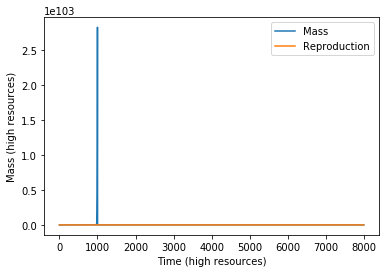

True

In [3]:
import matplotlib.pyplot as plt
########## minimisation #########
c = 0.4
rho = 0.2
cRho = [c, rho]
params = [t, mR0, alpha, M, a, k]

## Sanity check for the opt function
print(repro[-1])
    # minus to re-invert as the function is designed to invert with minus for use with optimise
# print(-Opt(cRho, params)) 
res_obj = minimize(Opt, cRho, args=(params)) 
print(res_obj)
c = res_obj.x[0]
rho = res_obj.x[1]
params = (alpha, M, a, c, rho, k)
mR = integrate.odeint(dRmdt, mR0, t, args = params)
mass = mR[:, 0]
repro = mR[:, 1]
plt.figure()
plt.plot(t, mass, label = "Mass")
plt.plot(t, repro, label =  "Reproduction")
plt.xlabel("Time (high resources)")
plt.ylabel("Mass (high resources)")
plt.legend()
plt.show()

mass[alpha] > mass[-1]

In [4]:
# # to scan parameter space
# ticker = 1
# rhoSpace = sc.arange(0, 1.1, 0.5) # .1 intervals
# cSpace = sc.arange(0, 1.1, 0.5)
# for i, rho in enumerate(rhoSpace):
#     for j, c in enumerate(cSpace):
#         # assign c and rho
#         cRho = [c, rho]
#         params = [t, mR0, alpha, M, a, k]
#         # run optimisation
#         res_obj = minimize(Opt, cRho, args=(params), method="NELDER-MEAD")
#         c = res_obj.x[0]
#         rho = res_obj.x[1]
#         params = (alpha, M, a, c, rho, k)
#         mR = integrate.odeint(dRmdt, mR0, t, args = params)
#         mass = mR[:, 0]
#         repro = mR[:, 1]
#         # if first iteration assign values
#         if i == 0 and j == 0:
#             OptRepro = repro[-1] 
#             Optrho = rho
#             Optc = c
#         #else compare and assign if better

#         if repro[-1] > OptRepro:
#             OptRepro = repro[-1]
#             Optrho = rho
#             Optc = c 
#             OptRes = res_obj
#             ticker = 1
#         if repro[-1] == OptRepro:
#             ticker = ticker + 1
            
# print(Optc)
# print(Optrho)
# print("Number of optimal results = ", ticker)
    

In [5]:
# c = Optc
# rho = Optrho
# params = (alpha, M, a, c, rho, k)
# mR = integrate.odeint(dRmdt, mR0, t, args = params)
# mass = mR[:, 0]
# repro = mR[:, 1]
# plt.figure()
# plt.plot(t, mass, label = "Mass")
# plt.plot(t, repro, label =  "Reproduction")
# plt.xlabel("Time (high resources)")
# plt.ylabel("Mass (high resources)")
# plt.legend()
# plt.show()
# OptRes

since the above yields `nan` below are listed the algorithms which have non-`nan` returns:
- NELDER-MEAD - seems very robust give good results on visual inspection
- POWELL  -  gives `nan` both params
- CG -  gives `nan` both params
- BFGS -  gives `nan` both params


In [6]:
# minimize
# print(type(mR))
# print(mR[alpha,0])
# print(mR[-1, 0])
# print( mR[-1,0]< mR[alpha, 0])


In [7]:
minimize

<function scipy.optimize._minimize.minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)>

# Brute Force Parameter Space Exploration
- taken from Luke Vassor's methodology

In [27]:
# function to find maximum value from a matrix
### imports
import matplotlib.pyplot as plt
import scipy as sc
from scipy import integrate
from scipy.optimize import minimize

def find_max(array):
    """
        A function to find the maximum of an array and return its indices

        Arguments:
            matrix {np.array} -- the matrix to find the max value of 

        Returns:
            {tuple} --  the indices of the maximum value

    """
    max_ind = sc.unravel_index(sc.argmax(array, axis=None), array.shape)
    return max_ind

#### set-up ####
## rho and c
resolution = 0.1# the resolution of the parameter space exploration for `rho` and `c`
rho_vec = sc.arange(0, 2, resolution)
c_vec = sc.arange(0, 2, resolution)

# array to store final reproduction values
# `c` will be row and `rho` columns, ith val is ith val in c_vec or jth val is jth in rho_vec
R0_array = sc.zeros((len(c_vec), len(rho_vec)))





days = 8000#1500 #  time to simulate over

# define starting parameters -- using cod values from west 2001 as a base/ballpark values

m0_start = 0.1 # starting mass at t_0
R0_start = 0 # starting reproduction at t_0, 0 because organism not yet mature in my sims
a = 2.15 # cost of new mass 
b =  0 # no need to calculate right now since i do it in function,could be done here to save time
# c = None

# reproductive cost 
M =  25000
alpha = 1000 # age of maturation (days)
# rho = None # reproductive scaling parameter
k =  0.01

# organising starting params for use

mR0 = sc.array([m0_start, R0_start]) # starting values for integration, [starting mass, starting repro]
t = sc.arange(0, days, 1) # t values for integration

    
for i, c in enumerate(c_vec):
    print(c)
    for j, rho in enumerate(rho_vec):
        
        ## simulate with params for the loop
        params = (alpha, M, a, c, rho, k) # tuple for integration arguments
        res = integrate.odeint(dRmdt, mR0, t, args=params)
        mass = res[:,0]
        R0 = res[:,1]
        
        ## check that the outcome is not a shrinking fish
        if mass[alpha] > mass[-1]:
            # if shrinking fish set R0 to -1 to differentiate from other viable results 
            R0[-1] = -1 # <-- change to NA to differentiate?
            
        ## check for nan values
        if sc.isnan(mass[-1]):
            R0[-1] = -2
        
        R0_array[i,j] = R0[-1]
        
max_ind = find_max(R0_array)
max_R0 = R0_array[max_ind]
c_opt = c_vec[max_ind[0]]
rho_opt = rho_vec[max_ind[1]]
        
        ## add a way to make sure that there is not more than one max
multi = sc.where(R0_array == R0_array[max_ind])
multi
        ## make fancy heatmap

0.0
0.1
0.2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in double_scalars
/usr/lib/python3/dist-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


0.3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: overflow encountered in double_scalars


0.4
0.5
0.6


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/scipy/integrate/odepack.py:218: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


0.7
0.8
0.9
1.0
1.1
1.2
1.3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: overflow encountered in double_scalars


1.4
1.5
1.6
1.7
1.8
1.9


(array([2, 2, 2, 2]), array([3, 5, 7, 9]))

In [ ]:
multi = sc.where(R0_array == R0_array[max_ind])
multi


In [28]:
print("rho is :", rho_opt)
print("c is :", c_opt)
"old rho is : 1.15"
"old c is : 0.01"

rho is : 0.3
c is : 0.2


'old c is : 0.01'

In [22]:
sc.nan

nan

In [30]:

R0_array[max_ind]
# R0_array


16045135.799562616

# Testing

## Test values

/usr/lib/python3/dist-packages/numpy/lib/scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):
/usr/lib/python3/dist-packages/numpy/lib/scimath.py:262: RuntimeWarning: invalid value encountered in log
  return nx.log(x)
/usr/lib/python3/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


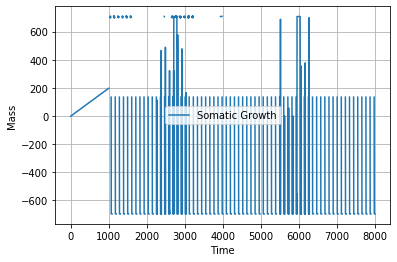

rho is:  0.3
c is:  0.2


In [31]:
## imports
import scipy as sc
from scipy import integrate

days = 8000#1500 #  time to simulate over

# define starting parameters -- using cod values from west 2001 as a base/ballpark values

m0 = 0.1 # starting mass at t_0
R0 = 0 # starting reproduction at t_0, 0 because organism not yet mature in my sims
a = 0.017 # cost of new mass 
b =  0 # no need to calculate right now since i do it in function,could be done here to save time
c = c_opt

# reproductive cost 
M =  25000
alpha = 1000 # age of maturation (days)
rho = rho_opt # reproductive scaling parameter
k =  0.01

# organising starting params for use

mR0 = sc.array([m0, R0]) # starting values for integration, [starting mass, starting repro]
t = sc.arange(0, days, 1) # t values for integration
params = (alpha, M, a, c, rho, k) # tuple for integration arguments


# integration
mR = integrate.odeint(dRmdt, mR0, t, args = params)
mass = mR[:, 0]
repro = mR[:, 1]


######plotting
import matplotlib.pyplot as plt

plt.figure()
plt.grid(True)
plt.plot(t, sc.log(mass), label = "Somatic Growth")
# plt.plot(t, repro, label = "Cumulative Reproduction")
plt.xlabel("Time")
plt.ylabel("Mass")
plt.legend()
# plt.savefig("../results/pretty_curve.png", dpi = 300)
plt.show()

print("rho is: ", rho)
print("c is: ", c)

In [13]:
mass[alpha] > mass[-1]
# mass[alpha] 
# mass[-1]

True

In [124]:
# array testing 
test = sc.array(range(20)).reshape(4,5)
# sc.unravel_index(sc.argmax(test))
max_ind = sc.unravel_index(sc.argmax(test, axis=None), test.shape)
max_ind
test
# sc.zeros((10,10)).shape


array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19]])

In [ ]:
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
def func(x):
    return x**2 + 10
def ode(x, t, a=2, b = 2):
    return 2*x + a + b
def odeint(x0, t, a=2, b=2):
    args = (a,b)
    return integrate.odeint(ode, 0, t, args=args)[-1]
def opt (x0, t, a=2, b=2):
    return -odeint(x0, t, a, b)
t = sc.arange(0,100,1)
inter = []
x = sc.linspace(-5, 5, 1000)
y = []
# for i in x:
#     y.append(odeint(i, t))
# a, b =[2,2]
# inter = odeint(x0 = 30, t = t, a=a, b=b)
# # inter = integrate.odeint(ode, 0, t, args=(a,b))
# print(minimize(opt, x0=30, args=(t,a,b)))
# print(minimize(func, x0=30))



# plt.figure()
# plt.plot(x, y)
# plt.show()

# print(minimize(fun = func, x0 = 30))
# print(t)
opt(x, t)

In [ ]:
integrate.odeint
